In [58]:
import os
import matplotlib.pyplot as plt
import pandas as pd
import time

from pyspark import SparkContext
from pyspark.sql.types import IntegerType
from pyspark.sql import Row
from pyspark.sql.functions import col

INPUT_PATH = "hdfs://BigDataHA/user/s277309/recsys_data/"
TEST = False # Enable to test the code on a sample dataset

features = [
    # Tweet features
    "text_tokens",      # List[long]    Ordered list of Bert ids corresponding to Bert tokenization of Tweet text
    "hashtags",         # List[string]  Tab separated list of hastags (identifiers) present in the tweet
    "tweet_id",         # String        Tweet identifier (unique)
    "present_media",    # List[String]  Tab separated list of media types. Media type can be in (Photo, Video, Gif)
    "present_links",    # List[string]  Tab separated list of links (identifiers) included in the Tweet
    "present_domains",  # List[string]  Tab separated list of domains included in the Tweet (twitter.com, dogs.com)
    "tweet_type",       # String        Tweet type, can be either Retweet, Quote, Reply, or Toplevel
    "language",         # String        Identifier corresponding to the inferred language of the Tweet
    "tweet_timestamp",  # Long          Unix timestamp, in sec of the creation time of the Tweet
    
    # Engaged-with User (i.e., Engagee) Features
    "engaged_with_user_id",                 # String    User identifier
    "engaged_with_user_follower_count",     # Long      Number of followers of the user
    "engaged_with_user_following_count",    # Long      Number of accounts the user is following
    "engaged_with_user_is_verified",        # Bool      Is the account verified?
    "engaged_with_user_account_creation",   # Long      Unix timestamp, in seconds, of the creation time of the account
    
    # Engaging User (i.e., Engager) Features
    "engaging_user_id",                     # String    User identifier   
    "engaging_user_follower_count",         # Long      Number of followers of the user
    "engaging_user_following_count",        # Long      Number of accounts the user is following
    "engaging_user_is_verified",            # Bool      Is the account verified?
    "engaging_user_account_creation",       # Long      Unix timestamp, in seconds, of the creation time of the account
    
    # Engagement features
    "engagee_follows_engager"   # Bool  Engagee follows engager?
]

features_idx = dict(zip(features, range(len(features))))

labels_idx = {
    # Engagement features (cont.)
    "reply_timestamp": 20,                  # Long      Unix timestamp (in seconds) of one of the replies, if there is at least one
    "retweet_timestamp": 21,                # Long      Unix timestamp (in seconds) of the retweet by the engaging user, if there is at least one
    "retweet_with_comment_timestamp": 22,   # Long      Unix timestamp (in seconds) of one of the retweet with comment by the engaging user, if there is at least one
    "like_timestamp": 23                    # Long      Unix timestamp (in seconds) of the like by the engaging user, if they liked the tweet
}

labels = ["TARGET_" + l for l in labels_idx.keys()]

In [59]:
if TEST:
    INPUT_PATH = "recsys_data_sample_generated/sample_0.0000"
    df = spark.read.parquet(INPUT_PATH)
else:
    schema = features + list(map(lambda l: f"TARGET_{l}", labels_idx))  # Column names
    df = sc.textFile(INPUT_PATH).map(lambda line: line.strip().split("\x01")).toDF(schema)

Map engagement timestamps to 0/1 labels

In [60]:
def binarize_label(el):
    if el != '':
        return 1
    return 0

binarize = spark.udf.register("binary", binarize_label, IntegerType())

# Documentation suggests not to use withColumn in a for loop.
# But it is not clear how to add multiple columns with a single call
binary_labels = []
for l in labels:
    bin_l = "binary_" + l
    df = df.withColumn(bin_l, binarize(df[l]))
    binary_labels.append(bin_l)

# Day of the week

In [61]:
def dow_engagement(data, target):
    """
    Count and plot of the number of positive engagements with respect to target, for day of the week.
    """
    
    def day_of_week(raw_data, features = None):
        """
        Extract day of the week (categorical) from tweet_timestamp. UTC time zone

        NOTE: koalas as default return weekday as a number. I guess this suggests wrong ordering,
              being Sunday closer to Monday than Friday. Verify effect on model's predictions
        """
        dow = spark.udf.register("DayOfWeek", lambda col_value: time.strftime("%A", time.localtime(int(col_value))))
        raw_data = raw_data.withColumn("day_of_week", dow(raw_data["tweet_timestamp"]))
        
        return raw_data
    
    
    target_dict = {
        'binary_TARGET_reply_timestamp': "reply",
        'binary_TARGET_retweet_timestamp': "retweet",
        'binary_TARGET_retweet_with_comment_timestamp': "retweet_with_comment",
        'binary_TARGET_like_timestamp': "like"
    }
    
    # Return dataframe with day_of_week column
    data = day_of_week(data)
    sliced_data = data.select('day_of_week', target)
    aggregated_data = sliced_data.groupBy('day_of_week').\
        agg({target: 'sum'}).\
        withColumnRenamed(f"sum({target})", f"number of {target_dict[target]}")
    
    pandas_df = aggregated_data.toPandas()
    pandas_df['day_of_week'] = pd.Categorical(pandas_df['day_of_week'],
                                              ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'])
    pandas_df.sort_values(by="day_of_week", inplace = True)
    
    pandas_df.plot.bar("day_of_week", f"number of {target_dict[target]}", title=target_dict[target])

CPU times: user 1.38 s, sys: 1.03 s, total: 2.41 s
Wall time: 6min 6s


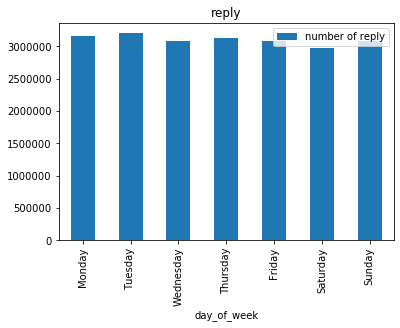

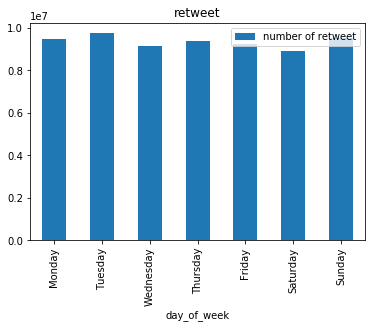

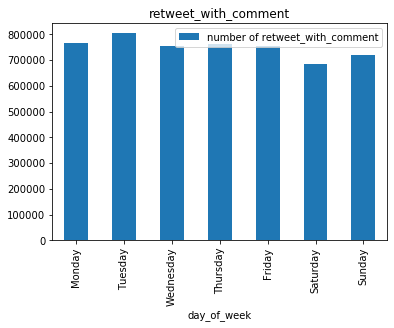

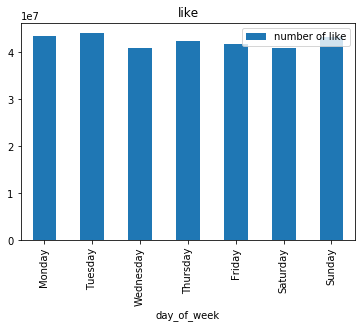

In [62]:
%%time
# TODO Correctly sort day of the week
for lab in binary_labels:
    dow_engagement(df, lab)

We observe same pattern for each target: exploration can be done on general interaction

# Hour of Day

In [63]:
def hod_engagement(data, target):
    """
    Count and plot of the number of positive engagements with respect to target, for day of the week.
    """
    
    def hour_of_day(raw_data, features = None):
        """
        Extract hour of day (numerical) from tweet_timestamp. UTC time zone
        """
        dow = spark.udf.register("HourOfDay", lambda col_value: time.strftime("%H", time.localtime(int(col_value))))
        raw_data = raw_data.withColumn("hour_of_day", dow(raw_data["tweet_timestamp"]))
        
        return raw_data
    
    
    target_dict = {
        'binary_TARGET_reply_timestamp': "reply",
        'binary_TARGET_retweet_timestamp': "retweet",
        'binary_TARGET_retweet_with_comment_timestamp': "retweet_with_comment",
        'binary_TARGET_like_timestamp': "like"
    }
    
    # Return dataframe with day_of_week column
    data = hour_of_day(data)
    sliced_data = data.select('hour_of_day', target)
    aggregated_data = sliced_data.groupBy('hour_of_day').\
        agg({target: 'sum'}).\
        withColumnRenamed(f"sum({target})", f"number of {target_dict[target]}")
    
    pandas_df = aggregated_data.toPandas().sort_values(by='hour_of_day')
    
    pandas_df.head()
    
    pandas_df.plot.bar("hour_of_day", f"number of {target_dict[target]}", title=target_dict[target])

CPU times: user 1.44 s, sys: 949 ms, total: 2.39 s
Wall time: 3min 48s


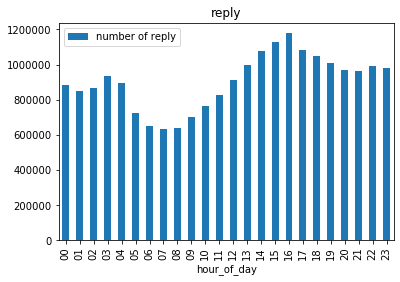

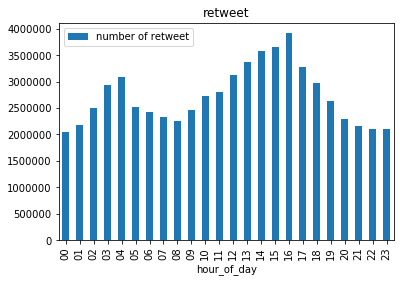

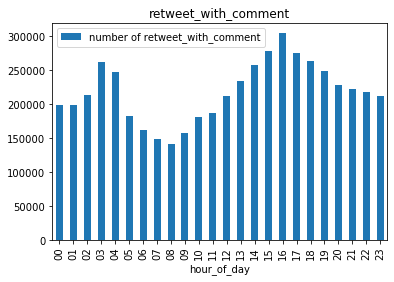

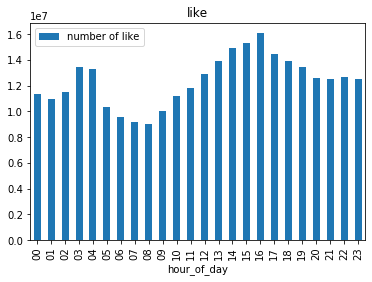

In [64]:
%%time
for lab in binary_labels:
    hod_engagement(df, lab)

We observe same pattern for each target: exploration can be done on general interaction